Import Libraries

In [109]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
from PIL import Image


Defining group members and image labels

In [110]:
group_members = ['Branis', 'Tanguy', 'Nelly', 'Nhial']
image_labels = ['neutral', 'smiling', 'surprised']
input_dir = 'images'
augmented_dir = 'augmented_images'
os.makedirs(augmented_dir, exist_ok=True)

Load & Display Sample Images


Showing images for: Branis


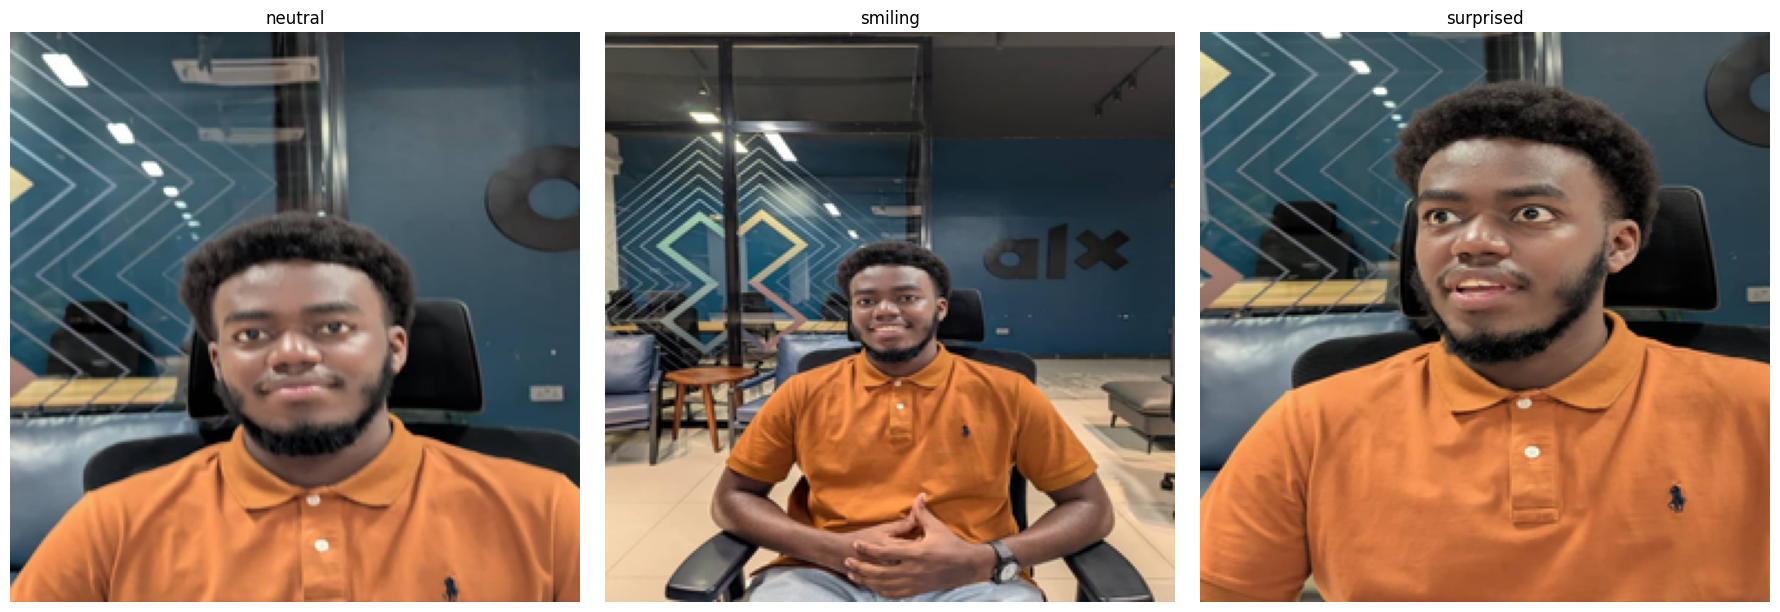

Showing images for: Tanguy


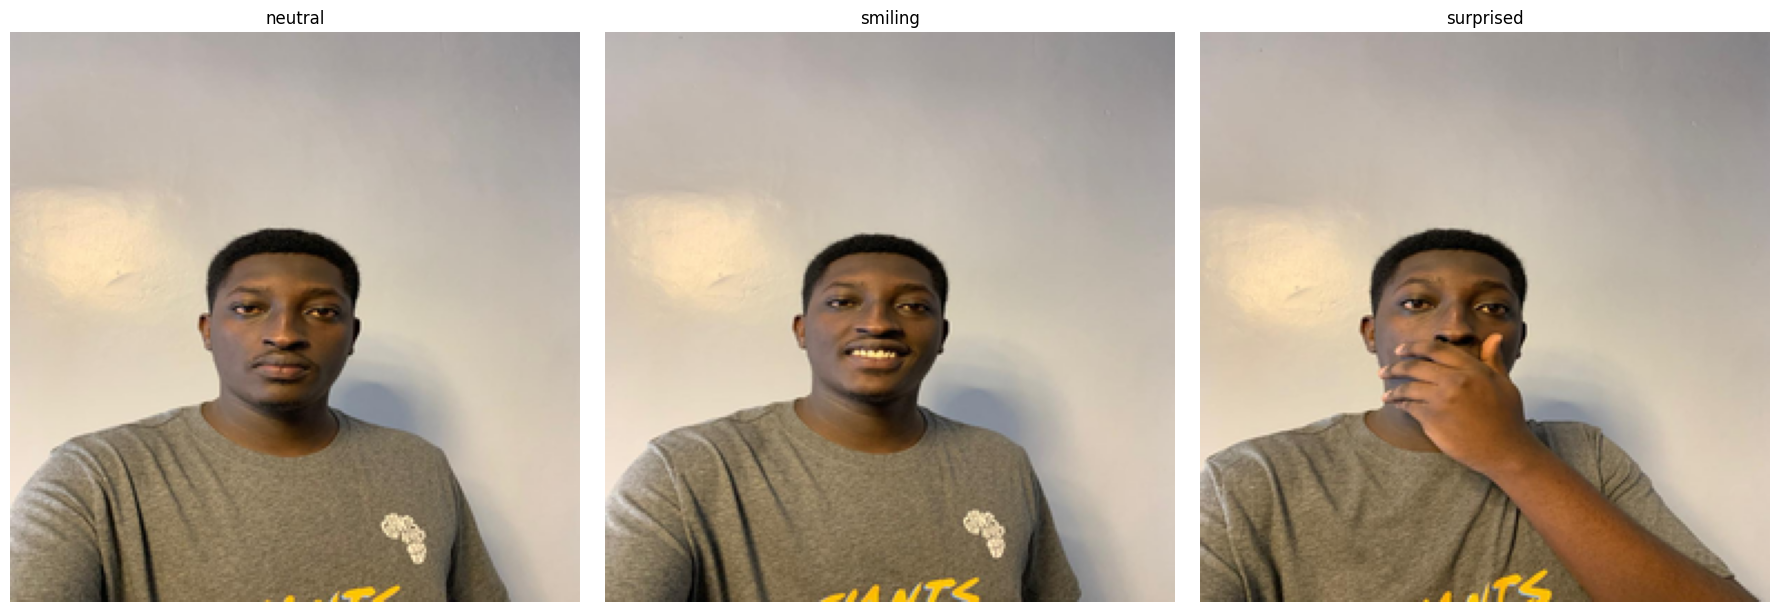

Showing images for: Nelly


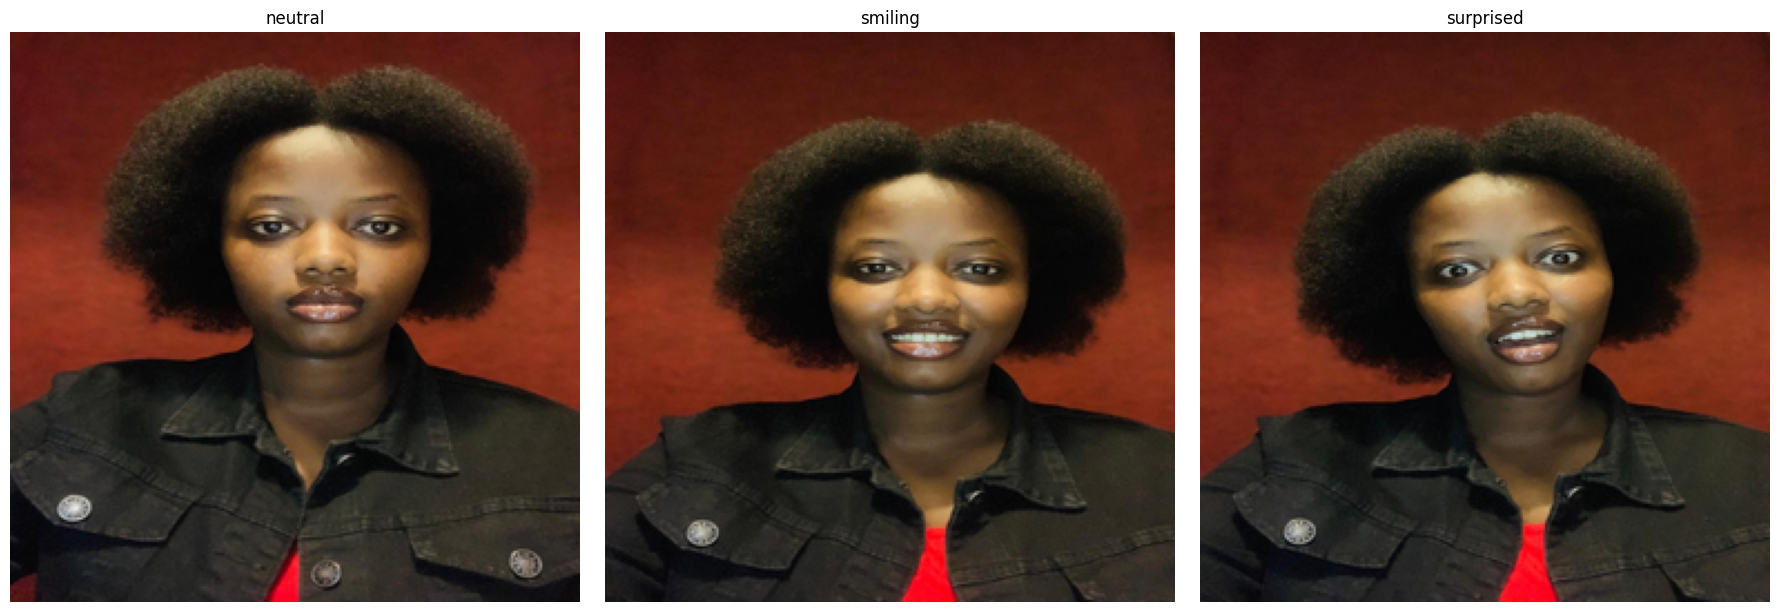

Showing images for: Nhial


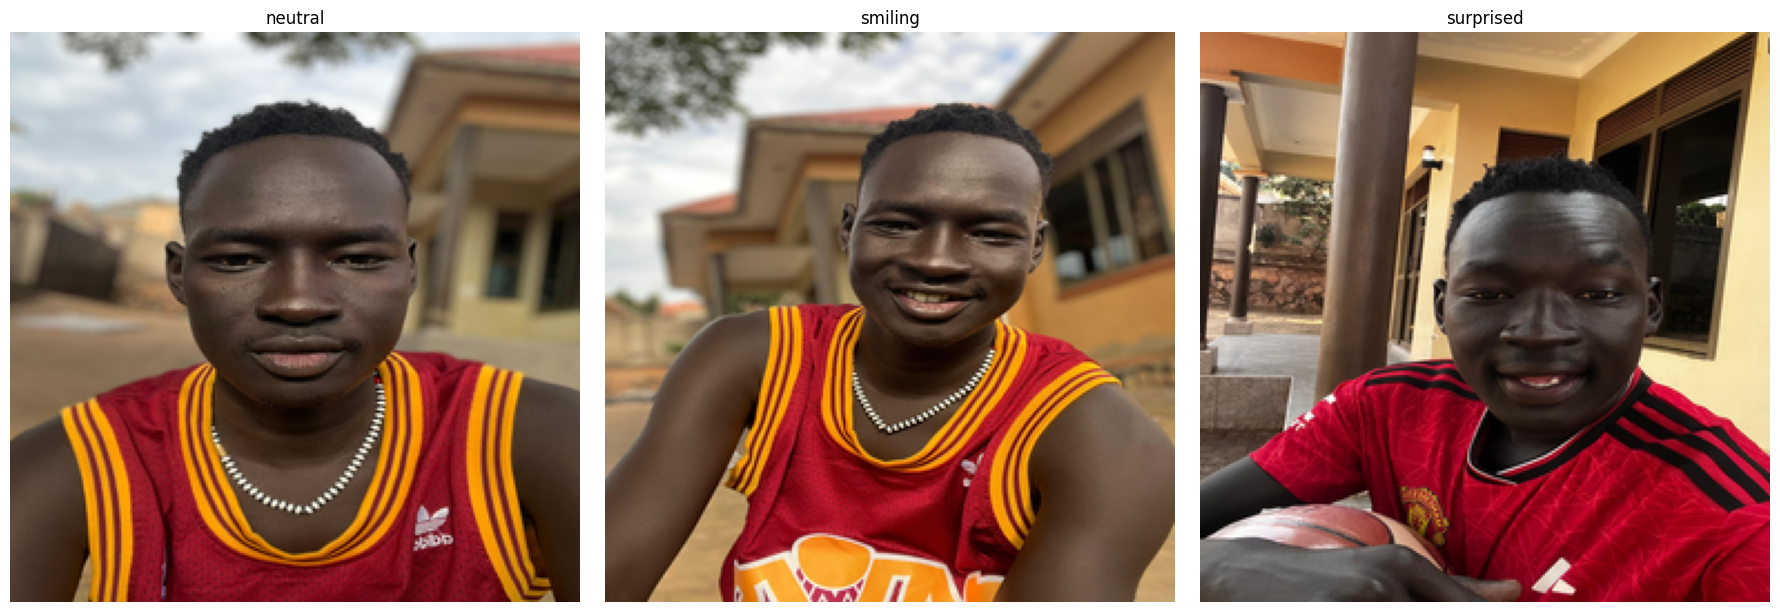

In [111]:
input_dir = '../Images'

all_images = {}

for member in group_members:
    member_dir = os.path.join(input_dir, member)
    member_images = {}
    
    for label in image_labels:
        img_path = os.path.join(member_dir, f'{label}.jpg')
        if os.path.exists(img_path):
            img = Image.open(img_path)
            # Use LANCZOS filter for sharp resizing
            img = img.resize((256, 256), Image.LANCZOS)
            member_images[label] = img
            
    all_images[member] = member_images

for member in all_images:
    print(f"Showing images for: {member}")
    fig, axs = plt.subplots(1, len(image_labels), figsize=(18, 6))
    for i, label in enumerate(image_labels):
        img = all_images[member].get(label, Image.new('RGB', (256, 256)))
        axs[i].imshow(img)
        axs[i].set_title(label)
        axs[i].axis('off')
    plt.tight_layout()
    plt.show()


Verifying All Member Folders Exist

In [112]:
for member in os.listdir(input_dir):
    member_path = os.path.join(input_dir, member)
    if not os.path.isdir(member_path):
        continue

    jpgs = [f for f in os.listdir(member_path) if f.lower().endswith('.jpg')]
    print(f"{member} has {len(jpgs)} JPG images")


Branis has 3 JPG images
Nelly has 3 JPG images
Nhial has 3 JPG images
Tanguy has 3 JPG images


Augmentation function

In [113]:
from PIL import Image, ImageOps
import os

# Function to create augmented versions of an image
def augment_image(image):
    return {
        'rotated': image.rotate(30),
        'flipped': ImageOps.mirror(image),
        'grayscale': ImageOps.grayscale(image).convert('RGB')
    }

augmented_images = {}

# Loop through original images and generate augmented ones
for member, imgs in all_images.items():
    member_augmented = {}
    for label, img in imgs.items():
        augmented_versions = augment_image(img)
        for aug_type, aug_img in augmented_versions.items():
            member_augmented[f'{label}_{aug_type}'] = aug_img
    augmented_images[member] = member_augmented

# Save all augmented images outside the notebooks folder
output_dir = "../augmented_images"
os.makedirs(output_dir, exist_ok=True)

for member, imgs in augmented_images.items():
    member_dir = os.path.join(output_dir, member)
    os.makedirs(member_dir, exist_ok=True)
    for label, img in imgs.items():
        img_path = os.path.join(member_dir, f"{label}.jpg")
        img.save(img_path)


Applying augmentations to all images

In [114]:
import numpy as np

output_dir = 'augmented_images'
os.makedirs(output_dir, exist_ok=True)

for member, imgs in augmented_images.items():
    member_dir = os.path.join(output_dir, member)
    os.makedirs(member_dir, exist_ok=True)
    print(f"Saving images for member: {member} into folder: {member_dir}")

    for name, img in imgs.items():
        save_path = os.path.join(member_dir, f"{name}.jpg")
        print(f"  Attempting to save image: {name}, type: {type(img)}")

        # Convert PIL Image to OpenCV format if needed
        if isinstance(img, Image.Image):
            img = np.array(img)                 # PIL to numpy array (RGB)
            img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)  # Convert RGB to BGR for OpenCV

        # Now save with OpenCV
        success = cv2.imwrite(save_path, img)
        if success:
            print(f"  Saved {save_path}")
        else:
            print(f"  ERROR: Failed to save {save_path}")


Saving images for member: Branis into folder: augmented_images\Branis
  Attempting to save image: neutral_rotated, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\neutral_rotated.jpg
  Attempting to save image: neutral_flipped, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\neutral_flipped.jpg
  Attempting to save image: neutral_grayscale, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\neutral_grayscale.jpg
  Attempting to save image: smiling_rotated, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\smiling_rotated.jpg
  Attempting to save image: smiling_flipped, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\smiling_flipped.jpg
  Attempting to save image: smiling_grayscale, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\smiling_grayscale.jpg
  Attempting to save image: surprised_rotated, type: <class 'PIL.Image.Image'>
  Saved augmented_images\Branis\surprised_rotated.jpg
  Attempting to

Histogram extraction

In [115]:
def extract_color_histogram(image_path, bins=96):
    try:
        image = Image.open(image_path).convert("RGB")
        histogram = image.histogram()
        histogram = np.array(histogram).astype('float32')
        histogram /= histogram.sum()  # Normalize
        return histogram
    except Exception as e:
        print(f"Error processing {image_path}: {e}")
        return None

Feature Extraction (Using Histograms)

In [116]:
def extract_histogram(image):
    image_np = np.array(image)
    hist_r, _ = np.histogram(image_np[:, :, 0], bins=16, range=(0, 256))
    hist_g, _ = np.histogram(image_np[:, :, 1], bins=16, range=(0, 256))
    hist_b, _ = np.histogram(image_np[:, :, 2], bins=16, range=(0, 256))
    return np.concatenate([hist_r, hist_g, hist_b])


 Extract and Save Features

In [117]:
feature_rows = []

for member in group_members:
    # Original images
    for label, img in all_images.get(member, {}).items():
        hist = extract_histogram(img)
        feature_rows.append({
            'member': member,
            'image_type': label,
            **{f'bin_{i}': val for i, val in enumerate(hist)}
        })

    # Augmented images
    for label_aug, img in augmented_images.get(member, {}).items():
        hist = extract_histogram(img)
        feature_rows.append({
            'member': member,
            'image_type': label_aug,
            **{f'bin_{i}': val for i, val in enumerate(hist)}
        })

features_df = pd.DataFrame(feature_rows)
features_df.to_csv('image_features.csv', index=False)
print(f"Extracted features for {features_df.shape[0]} images and saved to '../image_features.csv'")
features_df.head()


Extracted features for 48 images and saved to '../image_features.csv'


member       image_type  bin_0  bin_1  bin_2  bin_3  bin_4  bin_5  bin_6  \
0  Branis          neutral   2462   3339   7379  11832   7560   5986   2669   
1  Branis          smiling   1032   8727  10143   8120   5434   3472   2833   
2  Branis        surprised   3177   3580   5990   7811   5022   2172   2263   
3  Branis  neutral_rotated  12601   3150   6126   9731   6657   5461   2288   
4  Branis  neutral_flipped   2462   3339   7379  11832   7560   5986   2669   

   bin_7  ...  bin_38  bin_39  bin_40  bin_41  bin_42  bin_43  bin_44  bin_45  \
0   2026  ...   12841    6131    2680    1312     887     657     301     135   
1   2871  ...    4175    3622    2588    2808    4257     792     445      90   
2   1975  ...    6896    2629    1789    1041     616     425     165      55   
3   1827  ...   11750    5286    2268    1162     720     596     249     118   
4   2026  ...   12841    6131    2680    1312     887     657     301     135   

   bin_46  bin_47  
0      29     260  
1      31     130  
2      20      57  
3      24     113  
4      29     260  

[5 rows x 50 columns]